/opt/homebrew/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/var/folders/yx/3x_0hqj5317_rbwfqf2y5sv00000gn/T/ipykernel_98044/2826605074.py:96: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


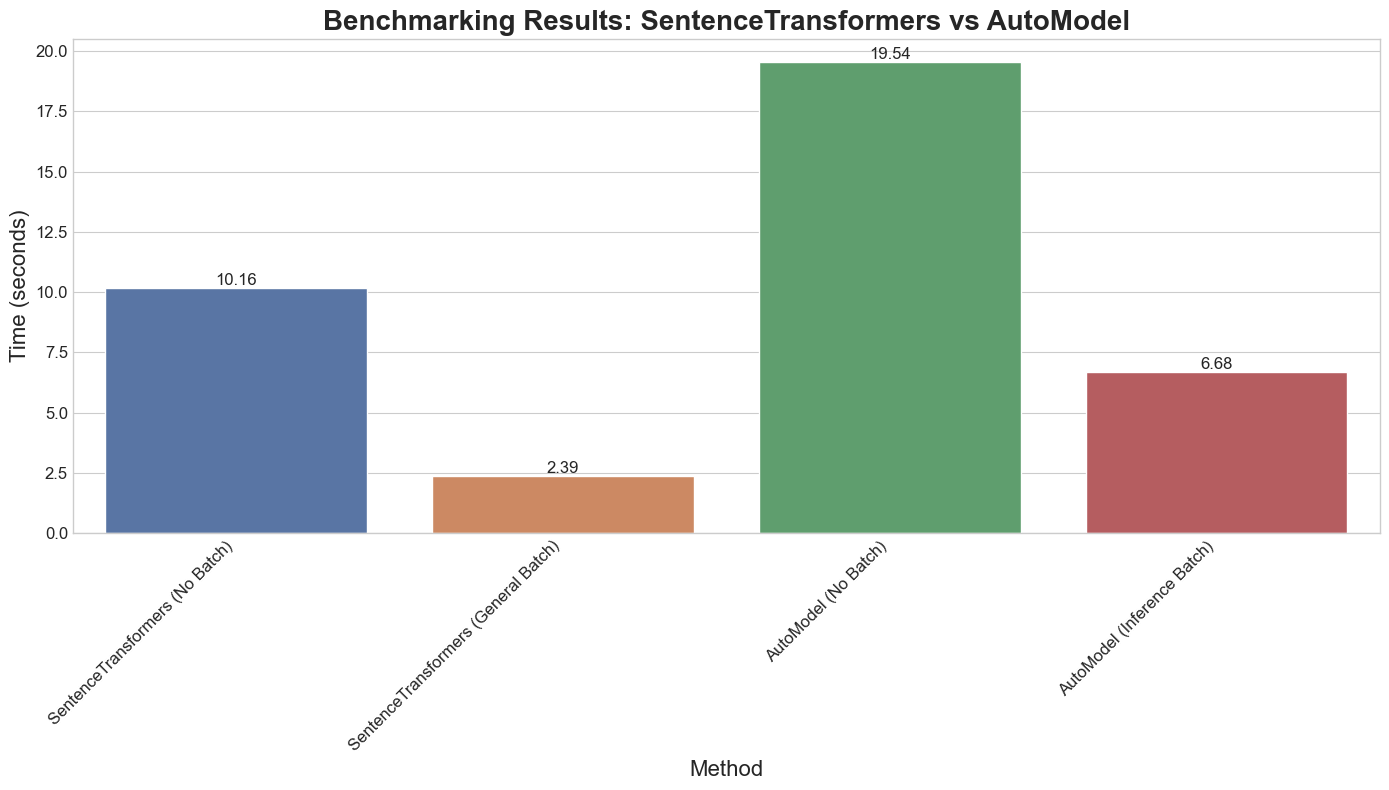

SentenceTransformers Speedup (General Batch vs No Batch): 4.26x
AutoModel Speedup (Inference Batch vs No Batch): 2.92x


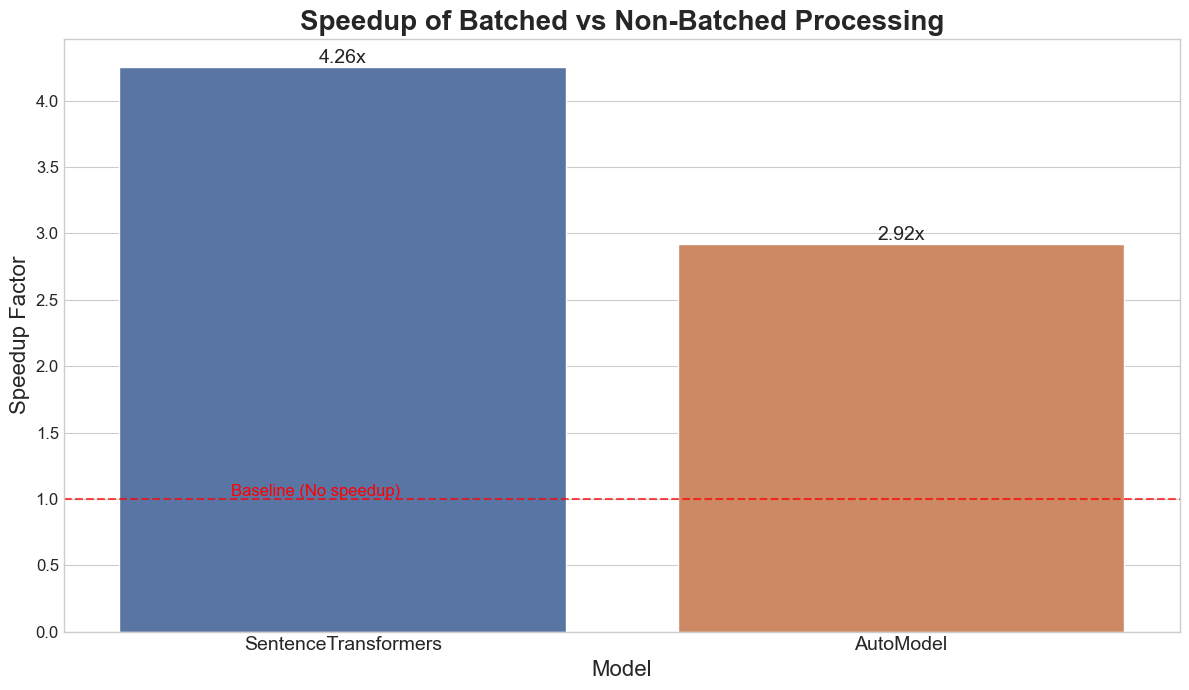

In [1]:
# Benchmarking SentenceTransformers and AutoModel with and without batching

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import timeit
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import batch
from batch import inference
import torch
from concurrent.futures import ThreadPoolExecutor
import time

# Load models
st_model = SentenceTransformer('all-MiniLM-L6-v2')
auto_model_name = "bert-base-uncased"
auto_tokenizer = AutoTokenizer.from_pretrained(auto_model_name)
auto_model = AutoModel.from_pretrained(auto_model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
auto_model.to(device)

# Helper function to generate random sentences
def generate_random_sentences(num_sentences, words_per_sentence=10):
    vocab = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'lazy', 'dog']
    return [' '.join(np.random.choice(vocab, size=words_per_sentence)) for _ in range(num_sentences)]

# Benchmark functions
def benchmark_st_no_batch(sentence):
    return st_model.encode([sentence])

@batch.dynamically
def st_with_general_batch(sents: list[str]):
    return st_model.encode(sents)

def benchmark_st_with_general_batch(sentence):
    return st_with_general_batch([sentence])

def auto_no_batch(**feats):
    with torch.no_grad():
        outputs = auto_model(**feats)
    return outputs.last_hidden_state

@inference.dynamically
def auto_with_inference_batch(feats):
    with torch.no_grad():
        outputs = auto_model(**feats)
    return outputs.last_hidden_state

def benchmark_auto_no_batch(sentence):
    inputs = auto_tokenizer([sentence], return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = auto_no_batch(**inputs)
    return outputs.cpu().numpy()

def benchmark_auto_with_inference_batch(sentence):
    inputs = auto_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = auto_with_inference_batch(inputs)
    return outputs.cpu().numpy()

# Run benchmarks
num_sentences = 1000
sentences = generate_random_sentences(num_sentences)

def run_benchmark(func, sentences):
    start_time = time.time()
    with ThreadPoolExecutor(max_workers=10) as executor:
        list(executor.map(func, sentences))
    end_time = time.time()
    return end_time - start_time

benchmarks = [
    ("SentenceTransformers (No Batch)", lambda: run_benchmark(benchmark_st_no_batch, sentences)),
    ("SentenceTransformers (General Batch)", lambda: run_benchmark(benchmark_st_with_general_batch, sentences)),
    ("AutoModel (No Batch)", lambda: run_benchmark(benchmark_auto_no_batch, sentences)),
    ("AutoModel (Inference Batch)", lambda: run_benchmark(benchmark_auto_with_inference_batch, sentences))
]

results = []
for name, func in benchmarks:
    time_taken = timeit(func, number=5) / 5  # Average over 5 runs
    results.append((name, time_taken))

# Prepare data for visualization
df = pd.DataFrame(results, columns=['Method', 'Time (s)'])

# Set a beautiful style for the plots
plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")

# Create bar plot with improved aesthetics
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Method', y='Time (s)', data=df)
plt.title('Benchmarking Results: SentenceTransformers vs AutoModel', fontsize=20, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=16)
plt.xlabel('Method', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for i, v in enumerate(df['Time (s)']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

# Improve the layout
plt.tight_layout()
plt.show()

# Calculate and display speedups
st_speedup = df.loc[0, 'Time (s)'] / df.loc[1, 'Time (s)']
auto_speedup = df.loc[2, 'Time (s)'] / df.loc[3, 'Time (s)']

print(f"SentenceTransformers Speedup (General Batch vs No Batch): {st_speedup:.2f}x")
print(f"AutoModel Speedup (Inference Batch vs No Batch): {auto_speedup:.2f}x")

# Create speedup bar plot with improved aesthetics
speedup_data = {
    'Model': ['SentenceTransformers', 'AutoModel'],
    'Speedup': [st_speedup, auto_speedup]
}

df_speedup = pd.DataFrame(speedup_data)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Model', y='Speedup', data=df_speedup)
plt.title('Speedup of Batched vs Non-Batched Processing', fontsize=20, fontweight='bold')
plt.ylabel('Speedup Factor', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for i, v in enumerate(df_speedup['Speedup']):
    ax.text(i, v, f'{v:.2f}x', ha='center', va='bottom', fontsize=14)

# Add a horizontal line at y=1 to show the baseline
plt.axhline(y=1, color='r', linestyle='--', alpha=0.7)
plt.text(-0.2, 1.02, 'Baseline (No speedup)', color='r', fontsize=12)

# Improve the layout
plt.tight_layout()
plt.show()
